# Introduction
> The below example showcases how you can utilise the FairML toolkit to extract feature dependence of your deployed model. In the below example we use a logistic regression model. You can however use any classifier or regressor

> In this example we will use a LightGBM model

> Documentation for this ToolKit can be found here: https://github.com/adebayoj/fairml

# Import modules

## Modules for model building and data processing
> Secondly, we will import the required libraries/modules

In [2]:
import pandas as pd
import numpy as np

import shap
import gc

from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Run example model for audit

## Read data 
> The first step of this example will be to load the relevant data. Ensure to have the 'dataset' folder in the same directory structure as the Python Notebook file which we are working on here

In [3]:
df = pd.read_csv('dataset/propublica_data_for_fairml.csv')

> Set our target column

In [4]:
TARGET_COL= "Two_yr_Recidivism"

> Drop the target column from the dataset, then asign the target column to variable 'y'

In [5]:
data = df.drop([TARGET_COL], axis=1)
y = df[TARGET_COL]

## Create train and validation set

> Split our dataset into a train and test set that we will use to build our model later on in this example

In [6]:
train_x, valid_x, train_y, valid_y = train_test_split(data, y, test_size=0.25, shuffle=True, stratify=y, random_state=42)

## ----------Dataset for  LightGBM Model  -----------------------
train_data=lgb.Dataset(train_x,label=train_y)
valid_data=lgb.Dataset(valid_x,label=valid_y)

## Setup our model
> In this section we setup the parameters of our model

> Set parametrs into a dictionary that we can use later 

In [7]:
params = {'metric' : 'auc',
          'boosting_type' : 'gbdt',
          'colsample_bytree' : 0.92,
#           'max_depth' : -1,
#           'n_estimators' : 200,
          'min_child_samples': 4, 
#           'min_child_weight': 0.1,
          'subsample': 0.85,
#           'verbose' : -1,
          'num_threads' : 4
}

> Train our model

In [10]:
lgbm = lgb.train(params,
                 train_data,
#                  2500,
                 valid_sets=valid_data
                 )

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52
[LightGBM] [Info] Number of data points in the train set: 4629, number of used features: 11
[LightGBM] [Info] Start training from score 0.455174


> Prediction model based on our chosen data

In [11]:
y_pred = lgbm.predict(valid_x)
score = roc_auc_score(valid_y, y_pred)
print("Overall AUC on validation (not test!): {:.3f}" .format(score))

Overall AUC on validation (not test!): 0.727


In [12]:
lgbm.params['objective'] = 'binary' ## workaround
%time shap_values = shap.TreeExplainer(lgbm).shap_values(data)

CPU times: user 6.92 s, sys: 23.3 ms, total: 6.95 s
Wall time: 3.85 s


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


# Plot our findings
> Plot the feature dependence as-well as the impact on the model output

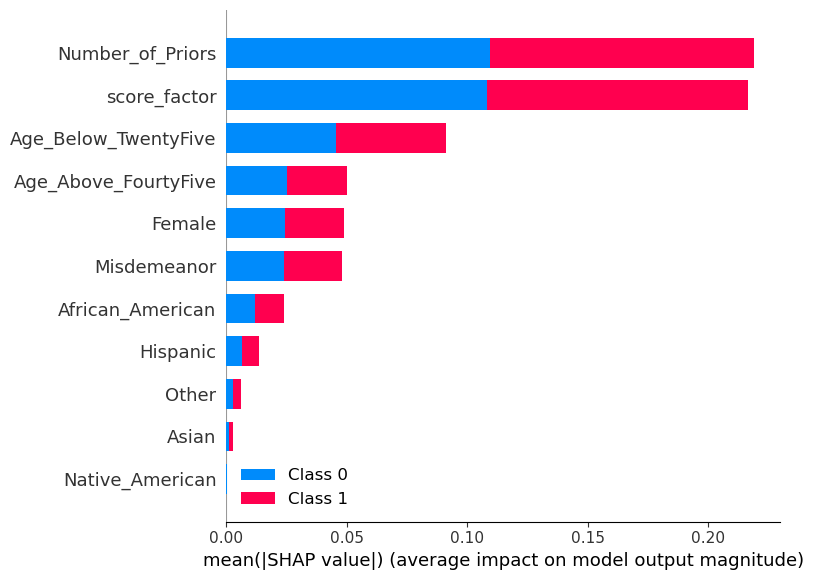

In [13]:
shap.summary_plot(shap_values, data)

> Plot a dependence plot based on a specific field 

CPU times: user 1.9 s, sys: 3.57 ms, total: 1.9 s
Wall time: 1.19 s


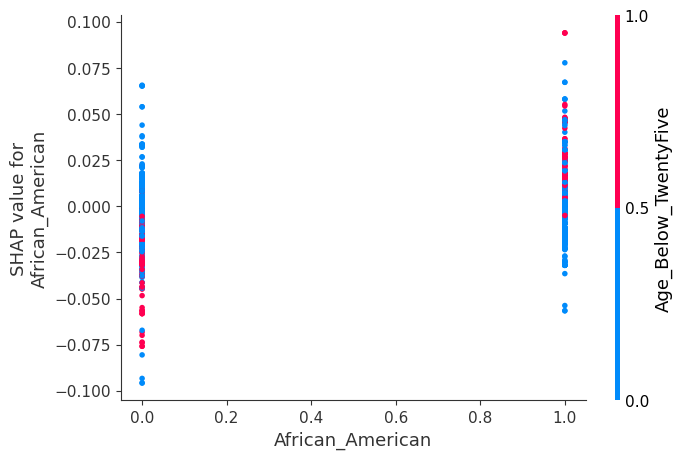

In [14]:
%time shap_values = shap.TreeExplainer(lgbm).shap_values(valid_x)
shap.dependence_plot("African_American", shap_values[1], valid_x)

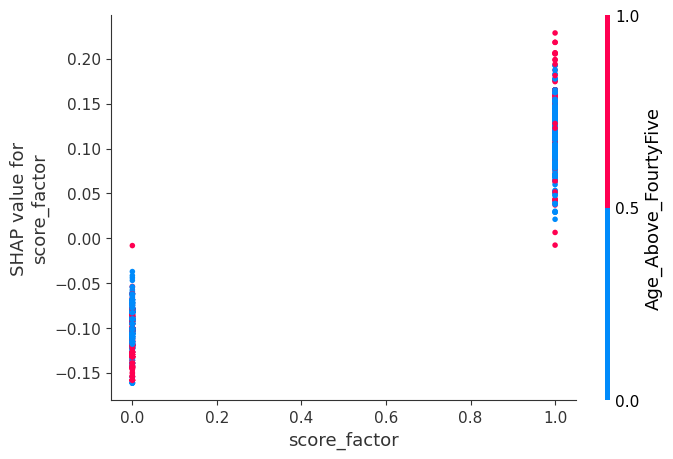

In [15]:
shap.dependence_plot("score_factor", shap_values[1], valid_x)


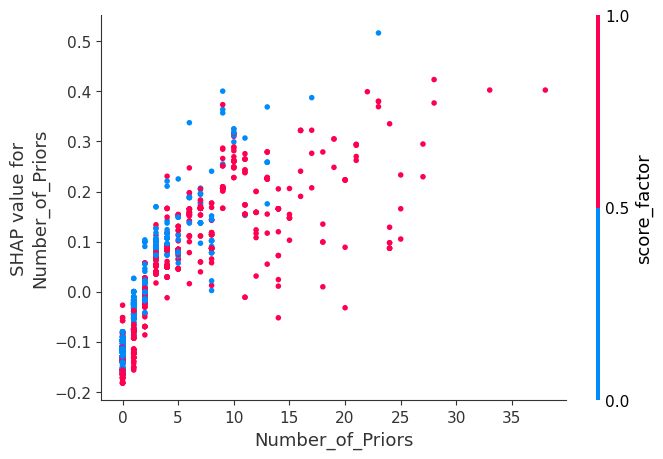

In [16]:
shap.dependence_plot("Number_of_Priors", shap_values[1], valid_x)
